In [40]:
## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import os
import random
import pickle
import torchvision
import shutil

C:\Users\przek\AppData\Local\Temp\ipykernel_19152\4197896627.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [41]:
torch.cuda.set_device(0)
device = torch.device("cuda")

def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_all_seeds(42)

# Read data

## Create val folder

In [43]:
def check_classes_amounts(path):
    classes = os.listdir(path)
    num_all = 0
    num_class = []
    for i in range(len(classes)):
        num_of_class = len(os.listdir(f"{path}/{classes[i]}"))
        num_class.append(num_of_class)
        num_all += num_of_class
    print(f"Number of all examples: {num_all}\nNumbers of every class: {num_class}")
    # return num_all, num_class

In [44]:
check_classes_amounts("./trafic_32")

Number of all examples: 39209
Numbers of every class: [210, 2220, 2250, 1410, 1980, 1860, 420, 1440, 1410, 1470, 2010, 1320, 2100, 2160, 780, 630, 420, 1110, 1200, 210, 360, 330, 390, 510, 270, 1500, 600, 240, 540, 270, 450, 780, 240, 689, 420, 1200, 390, 210, 2070, 300, 360, 240, 240]


In [45]:
def create_val_folder():
    sub_folders = os.listdir("./trafic_32")
    os.mkdir("./val_trafic_32")
    for sub_folder in sub_folders:
        os.mkdir(f"./val_trafic_32/{sub_folder}")

    for sub_folder in sub_folders:
        images_list = os.listdir(f"./trafic_32/{sub_folder}")
        to_move = random.sample(images_list, k=(len(images_list) // 5))
        for image in to_move:
            shutil.move(f"./trafic_32/{sub_folder}/{image}", f"./val_trafic_32/{sub_folder}/{image}")


In [46]:
create_val_folder()

In [47]:
check_classes_amounts("./trafic_32")

Number of all examples: 31368
Numbers of every class: [168, 1776, 1800, 1128, 1584, 1488, 336, 1152, 1128, 1176, 1608, 1056, 1680, 1728, 624, 504, 336, 888, 960, 168, 288, 264, 312, 408, 216, 1200, 480, 192, 432, 216, 360, 624, 192, 552, 336, 960, 312, 168, 1656, 240, 288, 192, 192]


In [48]:
check_classes_amounts("./val_trafic_32")

Number of all examples: 7841
Numbers of every class: [42, 444, 450, 282, 396, 372, 84, 288, 282, 294, 402, 264, 420, 432, 156, 126, 84, 222, 240, 42, 72, 66, 78, 102, 54, 300, 120, 48, 108, 54, 90, 156, 48, 137, 84, 240, 78, 42, 414, 60, 72, 48, 48]


In [3]:
trainset = datasets.ImageFolder("trafic_32/")

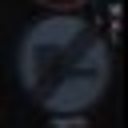

In [6]:
from IPython.display import display

image_num = 39208
scale = 4
display(trainset[image_num][0].resize(( int(trainset[image_num][0].width * scale), int(trainset[image_num][0].height * scale))))